In [46]:
import numpy as np
from math import pi,sqrt
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use('bmh')


class RandomWalk:
    
    np.random.seed(123)
    max_iter = int(1e8)
    Nr_walks = int(1e5)

    def __init__(self,epsilon=1e-1,init_var=0.95e-4,critical=False):
        self.epsilon = epsilon
        self.init_var = init_var
        self.var = init_var
        self.Sc = (pi/self.var)**(1/4)
        self.k = 2*pi/self.Sc
        self.delta = np.random.normal(scale=sqrt(self.var))
        self.critical = critical
        
    def reset(self):
        self.__init__(epsilon=self.epsilon,init_var=self.init_var,critical=self.critical)

    def get_var(self):
        return pi/self.Sc**4

    def set_new_Sc(self):
        self.Sc -= self.epsilon

    def one_walk(self):
        self.reset()
        iter_nr = 0
        if not self.critical:
            while self.Sc >= 1.0 and iter_nr < self.max_iter:
                self.set_new_Sc()
                inter_var = self.get_var() - self.var
                self.delta += np.random.normal(scale=sqrt(inter_var))
                self.var = self.get_var()
        else:
            while self.Sc >= 1.0 and iter_nr < self.max_iter:# and self.delta<1.0:
                self.set_new_Sc()
                inter_var = self.get_var() - self.var
                self.delta += np.random.normal(scale=sqrt(inter_var))
                self.var = self.get_var()
                if self.delta > 1.0:
                    return np.nan

        return self.delta

    def many_walks(self):
        deltas = np.zeros(self.Nr_walks)

        for i in tqdm(range(self.Nr_walks)):
            deltas[i] = self.one_walk()

        self.deltas = deltas[~np.isnan(deltas)]
    
    def gaussian(self,critical=False):
        sigma = sqrt(pi)/self.Sc**2 # just using the last optained scale
        delta_cont = np.linspace(-8,8,int(1e4))
        if not critical:
            return delta_cont,1/(sqrt(2*pi)*sigma)*np.exp(-delta_cont**2/(2*sigma**2))
        else:
            delta_cont = delta_cont[delta_cont<=1]
            p = 1/(sqrt(2*pi)*sigma)*(np.exp(-delta_cont**2/(2*sigma**2))-np.exp(-(2-delta_cont)**2/(2*sigma**2)))
            fudge = 2.2
            return delta_cont,fudge*p
        


In [35]:
RW_not_crit = RandomWalk()
RW_not_crit.many_walks();

100%|██████████| 100000/100000 [00:32<00:00, 3104.98it/s]


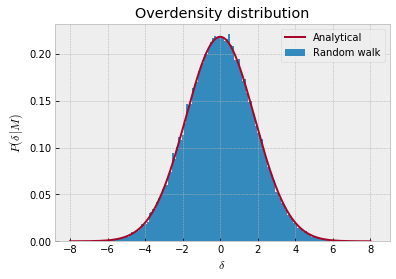

In [41]:
fig, ax = plt.subplots()

ax.hist(RW_not_crit.deltas,bins='auto',density=True,label='Random walk')
ax.plot(*RW_not_crit.gaussian(),label='Analytical')
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$P(\delta \, | M)$')
ax.set_title('Overdensity distribution')
ax.legend();

In [37]:
RW_crit = RandomWalk(epsilon=0.5e-1,critical=True)
RW_crit.many_walks()

100%|██████████| 100000/100000 [01:02<00:00, 1377.81it/s]


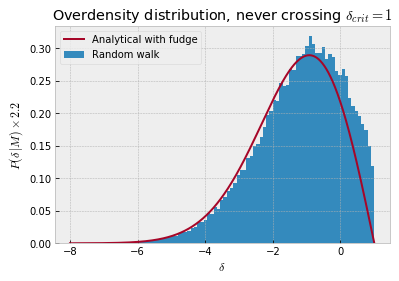

In [47]:
fig,ax = plt.subplots()
ax.hist(RW_crit.deltas,bins='auto',density=True,label='Random walk')
ax.plot(*RW_crit.gaussian(critical=True),label='Analytical with fudge')
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$P(\delta \, | M)$')
ax.set_title(r'Overdensity distribution, never crossing $\delta_{crit} = 1$')
ax.legend();